## Sequential testing
A common issue with classical A/B-tests, especially when you want to be able to detect small differences, is that the sample size needed can be prohibitively large. In many cases it can take several weeks, months or even years to collect enough data to conclude a test. 

*   The lower number of errors we require, the larger sample size we need.
* The smaller the difference we want to detect, the larger sample size is required.

Sequential sampling works in a very non-traditional way; instead of a fixed sample size, you choose one item (or a few) at a time, and then test your hypothesis. You can either:

* Reject the null hypothesis (H0) in favor of the alternate hypothesis (H1) and stop,
* Keep the null hypothesis and stop,
* unable to reach either conclusion with current observation and continue sampling.

### Advantage of Sequential testing over classic a/b testing


*   optimize necessary observation (sample size)
*   reduce the likelihood of error
* gives a chance to finish experiments earlier without increasing the possibility of false results

**N.B: Unlike classical fixed sample-size tests, where significance is only checked after all samples have been collected, this test will continously check for significance at every new sample and stop the test as soon as a significant result is detected, while still guaranteeing the same type-1 and type-2 errors as the fixed-samplesize test.**

## Common sequential testing algorithms
- [Evan Miller Simple Sequential A/B Testing](https://www.evanmiller.org/sequential-ab-testing.html)
- [Sequential probability ratio testing (SPRT)](https://en.wikipedia.org/wiki/Sequential_probability_ratio_test)

The Evan Miller sequential procedure for one-sided test works as follows:
* choose a sample size \(N\). [Here](https://www.evanmiller.org/ab-testing/sequential.html) is the link to define N
* Assign subjects randomly to the treatment and control, with 50% probability each.
* Track the number of incoming successes from the treatment group. Call this number \(T\).
* Track the number of incoming successes from the control group. Call this number \(C\).
* If \(T-C\) reaches \(2\sqrt{N}\), stop the test. Declare the treatment to be the winner.
* If \(T+C\) reaches \(N\), stop the test. Declare no winner.

The two-sided test is essentially the same, but with an alternate ending:
* If \(T-C\) reaches \(2.25\sqrt{N}\), stop the test. Declare the treatment to be the winner.
* If \(C-T\) reaches \(2.25\sqrt{N}\), stop the test. Declare the control to be the winner.
* If \(T+C\) reaches \(N\), stop the test. Declare no winner.

**N.B: This test completely ignores the number of failures in each group, which makes it significantly easier to implement in low-conversion settings. However**
- **If we hit the threshold without having reached statistical proof, we cannot continue the experiment.**
- **Even if preliminary evidence says that one version is terrible, we will keep losing conversions until we hit an arbitrarly pre-agreed threshold.**

### Sequential probability ratio testing (SPRT)
SPRT is based on the likelihood ratio statistic.
#### Variants of SPRT
- [Wald's(1947) sequential probability ratio test](http://en.wikipedia.org/wiki/Sequential_probability_ratio_test)
 * Wald's test uses one pair of observations at each stage and ignores tied observations and thus reduces a test of a single proportion.
- [Conditional sequential probability ratio test](http://www.jstor.org/stable/2346379?seq=1#page_scan_tab_contents)
 * used to calculate tied observations b/n two proportions. So, determining statistical significance with two distributional streams of data can be used for conditional sprt.
- [Sequential Generalized Likelihood Ratio Test](https://www.auduno.com/2014/12/25/rapid-a-b-testing-with-sequential-analysis/)
  * used to measure tied observation. Has stoping rule estimation problem.

We focus on conditional SPRT for this challenge.

General steps of conditional SPRT

1. Calculate critical upper and lower decision boundaries
2. Perform cummlative sum of the observation
3. calculate test statistics(likelihood ration) for each of the observations 
4. calculate upper and lower limits for exposed group
5. apply stopping

#### Stopping Rule

1. If the log probability ratio greater than or equal to the upper critical limit then the model reject the null hypothesis with the favor of alternative hypothesis (i.e. accept H1 (conclude that version two is better than version one)) and terminate the test.
2. If the log probability ratio less than or equal to the lower critical limit then accept the null hypothesis (i.e. conclude that there is no difference between the two groups) and terminate the test.
3. If neither critical limit is reached, conduct another trial and continue the test.

One-sided SPRT

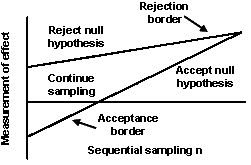

Two-sided SPRT

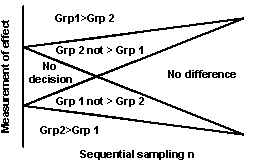

Next we will write python implementation for conditional SPRT


In [1]:
#Importing Libraries
import sys
import os
import pandas as pd
from datetime import timedelta
import math
import numpy as np
import Pylance

In [2]:
#importing local scripts
#Adding scripts path
sys.path.append(os.path.abspath(os.path.join('..')))
#Importing data manipulator scripts
from scripts.data_manipulator import get_group, get_answered

### Importing Working Data

In [3]:
#Reading Data
data= pd.read_csv('../data/AdSmartABdata.csv')
data.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [4]:
data['date'] = pd.to_datetime(data['date'])
# # data['hour'] = pd.to_datetime(data['hour'], format='%H')
# data['hour'] = [f':{t}' for t in data['hour']]
# # data['hour'] = pd.to_datetime(data['hour'])
data.head()


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [5]:
#Function that builds a bernouli dataframe
def beronlli_constructor(engagement:pd.Series, yes_count:pd.Series):
    engagement = engagement.tolist()
    yes_count = yes_count.tolist()
    ret_list = []
    for i in range(len(engagement)):
        ret_list.extend(yes_count[i] * [1])
        ret_list.extend((engagement[i] - yes_count[i]) * [0])
        
    return ret_list

In [6]:
def transform_data(df):
    '''
        segment data into exposed and control groups
        consider that SmartAd runs the experment hourly, group data into hours. 
            Hint: create new column to hold date+hour and use df.column.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
        create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
        Hint: Given engagement(sum of yes and no until current observation as an array) and success (yes countas an array), the method generates random binomial distribution
            #Example
                engagement = np.array([5, 3, 3])
                yes = np.array([2, 0, 3])       
                Output is "[1] 1 0 1 0 0 0 0 0 1 1 1", showing a binary array of 5+3+3 values
                of which 2 of the first 5 are ones, 0 of the next 3 are ones, and all 3 of
                the last 3 are ones where position the ones is randomly distributed within each group.
    '''
    # Get answered quesionnaires only
    clean_data = get_answered(df=df, column1='yes', column2='no')

    #Segmenting data into exposed and control groups
    control_group = get_group(df=clean_data,from_column='experiment',classification='control')
    exposed_group = get_group(df=clean_data,from_column='experiment',classification='exposed')

    #Grouping Data using hours
    #For the control group
    control_group['date-time'] = control_group['date'] + control_group['hour'].apply(lambda x: timedelta(hours=x))
    #For the exposed group
    exposed_group['date-time'] = exposed_group['date'] + exposed_group['hour'].apply(lambda x: timedelta(hours=x))

    #Generating engagment and yes array based on date-time column grouping
    #control Group
    for_control_group = pd.DataFrame()
    for_control_group['engagement'] = control_group.groupby('date-time').agg({'yes':'count'}).iloc[:,0]
    for_control_group['yes_count'] = control_group.groupby('date-time').agg({'yes': 'sum'}).iloc[:,0]
    #Build bernouli series
    control_group_bernouli = beronlli_constructor(for_control_group['engagement'],for_control_group['yes_count'])

    #exposed Group
    for_exposed_group = pd.DataFrame()
    for_exposed_group['engagement'] = exposed_group.groupby('date-time').agg({'yes':'count'}).iloc[:,0]
    for_exposed_group['yes_count'] = exposed_group.groupby('date-time').agg({'yes': 'sum'}).iloc[:,0]
    #Build bernouli series
    exposed_group_bernouli = beronlli_constructor(for_exposed_group['engagement'],for_exposed_group['yes_count'])

    data_stream = (control_group_bernouli, exposed_group_bernouli)

    return data_stream

In [7]:
data_stream = transform_data(data)

<ipython-input-6-7ed7daf1c6fe>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_group['date-time'] = control_group['date'] + control_group['hour'].apply(lambda x: timedelta(hours=x))
<ipython-input-6-7ed7daf1c6fe>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exposed_group['date-time'] = exposed_group['date'] + exposed_group['hour'].apply(lambda x: timedelta(hours=x))


In [8]:
#REFERENCE
# A Conditional Sequential Test for the Equality of Two Binomial Proportions
# William Q. Meeker, Jr
# Journal of the Royal Statistical Society. Series C (Applied Statistics)
# Vol. 30, No. 2 (1981), pp. 109-115

In [9]:
class ConditionalSPRT:
    def __init__(self,exposed,control,odd_ratio,alpha=0.05,beta=0.10,stop=None):
        self.x = exposed
        self.y = control
        self.t1 = odd_ratio
        self.alpha = alpha
        self.beta = beta
        self.stop = stop

    def ConditionalSPRT(self,x,y,t1,alpha=0.05,beta=0.10,stop=None):
        """
        #
        # Meeker's SPRT for matched `x` (treatment) and `y` (control), 
        # both indicator responses, likelihood ratio t1, error rates alpha and beta,
        # and (optionally) truncation after trial stop.
        #
        # The return variable contains these elements:
        #(outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)
        # * outcome:   "continue," "reject null," or "accept null".
        # * n: number observation used for the decsion
        # * k:     Index at which the outcome decision was made (or NA)
        # * l:     lower critical point
        # * u:     upper critical point
        # * truncate_decision: The approximate decision made after truncate point
        # * truncated: If the test was truncated, the value of `n.0`; NA otherwise
        # * x1:       Original data `x`, cumulative
        # * r:         Cumulative sum of x+y
        # * stats:     Series of cumulative sums of log probability ratios
        # * limits:    Two rows giving lower and upper critical limits, respectively
        #
        """
        if t1<=1:
            printLog('warning',"Odd ratio should exceed 1.")
        if (alpha >0.5) | (beta >0.5):
            printLog('warning',"Unrealistic values of alpha or beta were passed."
                    +" You should have good reason to use large alpha & beta values")
        if stop!=None:
            stop=math.floor(n0)

        def comb(n, k):
            return math.factorial(n) // math.factorial(k) // math.factorial(n - k)
        
        def lchoose(b, j):
            a=[]
            if (type(j) is list) | (isinstance(j,np.ndarray)==True):
                if len(j)<2:
                    j=j[0]
            if (type(j) is list) | (isinstance(j,np.ndarray)==True):
                for k in j:
                    n=b
                    if (0 <= k) & (k<= n):
                        a.append(math.log(comb(n,k)))
                    else:
                        a.append(0)
            else:
                n=b
                k=j
                if (0 <= k) & (k<= n):
                    a.append(math.log(comb(n,k)))
                else:
                    a.append(0)

            return np.array(a)

        def g(x,r,n,t1,t0=1):
            """
            #
            # Meeker's (1981) function `g`, the log probability ratio.
            # 
            """
            return -math.log(h(x,r,n,t1))+math.log(h(x,r,n,t0))

        def h(x,r,n,t=1):
            """
            #
            # Reciprocal of Meeker's (1981) function `h`: the conditional probability of 
            # `x` given `r` and `n`, when the odds ratio is `t`.
            #
            # `x` is his "x1", the number of positives in `n` control trials.
            # `r` is the total number of positives.
            # `n` is the number of (control, treatment) pairs.
            # `t` is the odds ratio.
            #
            """
            return f(r,n,t,offset=ftermlog(x,r,n,t))

        def f(r,n,t,offset=0):
            """#
            # Meeker's (1981) function exp(F(r,n,t)), proportional to the probability of 
            #  `r` (=x1+x2) in `n` paired trials with an odds ratio of `t`.
            #
            # This function does *not* vectorize over its arguments.
            #"""
            upper=max(0,r-n)
            lower=min(n,r)
            rng=list(range(upper,lower+1))
            return np.sum(fterm(rng,r,n,t,offset))

        def fterm(j,r,n,t,offset=0):
            ftlog=ftermlog(j,r,n,t,offset)
            return np.array([math.exp(ex) for ex in ftlog])

        def ftermlog(j,r,n,t,offset=0):
            """
            #
            # Up to an additive constant, the log probability that (x1, x1+x2) = (j, r) 
            # in `n` paired trials with odds ratio of `t`.
            #
            # `offset` is used to adjust the result to avoid under/overflow.
            #
            """
            xx=r-j
            lch=lchoose(n,j)
            lchdiff=lchoose(n,xx)
            lg=np.array(j)*math.log(t)
            lgsum=lch+lchdiff
            lgsum2=lgsum+lg
            lgdiff=lgsum2-offset

            return lgdiff

        def logf(r,n,t,offset=0):
            """
            #
            # A protected vesion of log(f), Meeker's function `F`.
            #
            """
            z=f(r,n,t,offset)
            if z>0:
                return math.log(z)
            else:
                return np.nan

        def clowerUpper(r,n,t1c,t0=1,alpha=0.05,beta=0.10):
            """
            #
            # Meeker's (1981) functions c_L(r,n) and c_U(r,n), the  critical values for x1.
            # 0 <= r <= 2n; t1 >= t0 > 0.
            #
            """
            offset=ftermlog(math.ceil(r/2),r,n,t1c)
            z=logf(r,n,t1c,logf(r,n,t0,offset)+offset)
            a=-math.log(alpha/(1-beta))
            b=math.log(beta/(1-alpha))
            lower=b
            upper=1+a
            return (np.array([lower,upper])+z)/math.log(t1c/t0)

        l=math.log(beta/(1-alpha))
        u=-math.log(alpha/(1-beta))
        sample_size=min(len(x),len(y))
        n=np.array(range(1,sample_size+1))

        if stop!=None:
            n=np.array([z for z in n if z<=stop])
        x1=np.cumsum(x[n-1])
        r=x1+np.cumsum(y[n-1])
        stats=np.array(list(map(g,x1, r, n, [t1]*len(x1)))) #recurcively calls g
        #
        # Perform the test by finding the first index, if any, at which `stats`
        # falls outside the open interval (l, u).
        #
        clu=list(map(clowerUpper,r,n,[t1]*len(r),[1]*len(r),[alpha]*len(r), [beta]*len(r)))
        limits=[]
        for v in clu:
            inArray=[]
            for vin in v:
                inArray.append(math.floor(vin))
            limits.append(np.array(inArray))
        limits=np.array(limits)

        k=np.where((stats>=u) | (stats<=l))
        cvalues=stats[k]
        if cvalues.shape[0]<1:
            k= np.nan
            outcome='Unable to conclude.Needs more sample.'
        else:
            k=np.min(k)
            if stats[k]>=u:
                outcome=f'Exposed group produced a statistically significant increase.'
            else:
                outcome='Their is no statistically significant difference between two test groups'
        if (stop!=None) & (k==np.nan):
        #
        # Truncate at trial stop, using Meeker's H0-conservative formula (2.2).
        # Leave k=NA to indicate the decision was made due to truncation.
        #
            c1=clowerUpper(r,stop,t1,alpha,beta)
            c1=math.floor(np.mean(c1)-0.5)
            if x1[n0]<=c1:
                truncate_decision='h0'
                outcome='Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
            else:
                truncate_decision='h1'
                outcome=f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
            truncated=stop
        else:
            truncate_decision='Non'
            truncated=np.nan
        return (outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)

In [10]:
#Calculate odd Value
control_df = pd.DataFrame(data_stream[0])
exposed_df = pd.DataFrame(data_stream[1])
#counting values
p1_no_count, p1_yes_count = exposed_df.value_counts().values
p2_no_count, p2_yes_count = control_df.value_counts().values

p1 =  p1_yes_count / (p1_no_count + p1_yes_count)
p2 =  p2_yes_count / (p2_no_count + p2_yes_count)

odd_value = (p1/ (1 - p1)) / (p2/ (1 - p2))
odd_value

1.0764087870105061

In [14]:
# Initialize the ConditionalSPRT class
cond_sprt = ConditionalSPRT(exposed=np.array(data_stream[1]),control=np.array(data_stream[0]),odd_ratio=odd_value)
result = cond_sprt.ConditionalSPRT(x=cond_sprt.x,y=cond_sprt.y,t1=cond_sprt.t1)

# The return variable contains these elements:
        #(outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)
        # * outcome:   "continue," "reject null," or "accept null".
        # * n: number observation used for the decsion
        # * k:     Index at which the outcome decision was made (or NA)
        # * l:     lower critical point
        # * u:     upper critical point
        # * truncate_decision: The approximate decision made after truncate point
        # * truncated: If the test was truncated, the value of `n.0`; NA otherwise
        # * x1:       Original data `x`, cumulative
        # * r:         Cumulative sum of x+y
        # * stats:     Series of cumulative sums of log probability ratios
        # * limits:    Two rows giving lower and upper critical limits, respectively
        #

In [40]:
#Our final Decision
result[0]

'Unable to conclude.Needs more sample.'

In [64]:
#Plotting the result
limits = result[10].tolist()
lower_limit = [value[0] for value in limits]
upper_limit = [value[1] for value in limits]

x1 = result[7].tolist()
r = result[8]

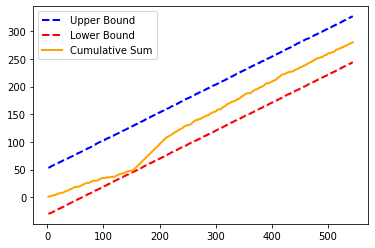

In [70]:
import matplotlib.pyplot as plt
plt.plot(r, upper_limit,color = 'blue', linewidth=2, linestyle='dashed',label='Upper Bound')
plt.plot(r, lower_limit,color = 'red', linewidth=2, linestyle='dashed',label='Lower Bound')
plt.plot(r, x1,color = 'orange', linewidth=2, linestyle='solid',label='Cumulative Sum')
plt.legend()
plt.show()